# LSTM Code <br>
NOTE: A powerful GPU and alot of RAM is required to run the following code. Because of this, certain variables need to be changed to experiment for different filtered data and hyperparameters. Values that need to be changed to obtain other results are noted in the markdown text for each section as required.

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import RobustScaler
import hickle as hkl

### 1) Reading the Data


*NOTE: Specified `DATA_PATH` should contain the directories for train dataset and the various filtered train datasets. The raw data is under \train, the filtered data is under (for example) \train0.3 for a threshold of 0.3*

*NOTE2: Change `FILTERED` to Choose whether to use filtered data or not*

In [2]:
DATA_PATH = 'C:\\Users\\Sean\\Desktop\\AI4E_A3' # Directory containing all the data (filtered and unfiltered data directories under this)
FILTERED = '' # Whether to use the filtered data. Empty string for raw unfiltered data, otherwise '0.15', '0.3', '0.5' or '0.8' to select the filtered data directory with the corresponding threshold


# The dataset is sampled at 500 Hz
DATA_FREQUENCY = 500 

# Simple sorter function to sort the file strings in the correct order (by subj#, series#):
file_name_sorter = lambda string_list: sorted(string_list, key=lambda s: (int(re.search(r'subj(\d+)', s).group(1)), int(re.search(r'series(\d+)', s).group(1)) if re.search(r'series(\d+)', s) else 0))


# Take the first 6 series of each subject to be the training set
train_data_files = file_name_sorter(glob(os.path.join(DATA_PATH,'train'+FILTERED, 'subj*_series[1-6]_data.csv')))
train_event_files = file_name_sorter(glob(os.path.join(DATA_PATH, 'train', 'subj*_series[1-6]_events.csv')))

# Take the 7th and 8th series to be the test set
test_data_files = file_name_sorter(glob(os.path.join(DATA_PATH, 'train'+FILTERED, 'subj*_series[7-8]_data.csv')))
test_event_files = file_name_sorter(glob(os.path.join(DATA_PATH, 'train', 'subj*_series[7-8]_events.csv')))


# List comprehension explanation: Removes the first column (id_frame) and convert time series to NUMPY array, each row is a sample and each column is a feature or label. Put all of the subj-series into a list
# Train data x, y
x_train_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in train_data_files] # EEG signals
y_train_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in train_event_files] # labels

# Test data x, y
x_test_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in test_data_files] # EEG signals
y_test_data_series = [pd.read_csv(file, index_col=None, header=0).iloc[:,1:].to_numpy(dtype=np.float16) for file in test_event_files] # labels

### 2) Scaling the data based on the training signals

In [3]:
scaler = RobustScaler()

scaler = scaler.fit(np.concatenate(x_train_data_series, axis=0))

# Scale the EEG data for both the train and test set, but only scale based on the train set knowledge
x_train_data_series = [scaler.transform(series) for series in x_train_data_series]
x_test_data_series = [scaler.transform(series) for series in x_test_data_series]

### 3) Convert the training data into LSTM input format

*NOTE: Specify the following hyperparameters: `T_LOOKBACK`, `SAMPLE_REDUCTION` and `NON_EVENT_THRESHOLD` to specify how the model should use and learn from the time series data* 

In [4]:
T_LOOKBACK = 3 # How many seconds to look back
SAMPLE_REDUCTION = 50 # How much to downsample the data by (e.g. for 10 means 500/10 = 50 Hz, 50 means 500/50 = 10 Hz). This mimics a reduced sampling rate of EEG data by taking every nth reading
NON_EVENT_THESHOLD = 0.10 # Proportion of extra non-event (0s) data to put into the training set. Higher the value to put in more non-event data

def generate_input_dataset(x_train_data_series, y_train_data_series):
    """ Generate the input dataset for the LSTM model. This is done by looking back a fixed amount of time and downsampling the data. """

    n_frames = T_LOOKBACK * DATA_FREQUENCY # Number of data frames to look back NOT REDUCED
    x = [] # Train data
    y = [] # Train labels

    # Go through each series/events file separately
    for series_data, series_events in zip(x_train_data_series, y_train_data_series):
        
        for i in range(n_frames-1, series_data.shape[0]-1): # Go through all the possible predictable frames (frames that have hisotrical data avaiable) NOTE: -1 because sometimes the filtered data has 1 more frame
            
            if np.sum(series_events[i]) > 0 or (np.random.random() < NON_EVENT_THESHOLD): # If there is an event at this frame # or randomly sample some of the non-event frames

                x.append(series_data[i-n_frames+SAMPLE_REDUCTION:i+SAMPLE_REDUCTION:SAMPLE_REDUCTION]) # Append the data
                y.append(series_events[i]) # Append the label for the event with the historicla data in mind
                

    return np.array(x), np.array(y)

x_train, y_train = generate_input_dataset(x_train_data_series, y_train_data_series)


### 4) Shuffle the dataset
Shuffling is important otherwise each training step is too similar to the previous one

In [5]:
shuffle_idx = np.random.permutation(x_train.shape[0])
x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]

### 5) Set up the LSTM network

In [6]:
model = tf.keras.models.Sequential(layers=[

    tf.keras.layers.Input((x_train.shape[1], x_train.shape[2]), name='input'), # Input should be frames*features (e.g. 20*32)

    tf.compat.v1.keras.layers.CuDNNLSTM(units=64, name='LSTM'),
    tf.keras.layers.Dropout(0.5, name='dropout'),

    tf.keras.layers.Dense(6, activation='sigmoid', name='dense') # Output layer, 6 independent possible events from 0-1

    ], name='LSTM_model'
)

loss=tf.keras.losses.binary_crossentropy # Binary cross-entropy treats each label prediction as a separate binary classification problem.
optimizer=tf.keras.optimizers.Adam()


model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]) # AUC - minmise false positives, maximise true positives

model.summary()


Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (CuDNNLSTM)            (None, 64)                25088     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 25,478
Trainable params: 25,478
Non-trainable params: 0
_________________________________________________________________


### 6) Train the model

In [7]:
history = model.fit(x_train, y_train, epochs=5, batch_size=2048)

Epoch 1/5
2427/2427 [==============================] - 22s 8ms/step - loss: 0.2597 - accuracy: 0.1573 - precision: 0.0710 - recall: 0.0024 - auc: 0.5234
Epoch 2/5
2427/2427 [==============================] - 18s 7ms/step - loss: 0.2522 - accuracy: 0.1852 - precision: 0.1429 - recall: 4.8225e-07 - auc: 0.5584
Epoch 3/5
2427/2427 [==============================] - 17s 7ms/step - loss: 0.2442 - accuracy: 0.1695 - precision: 0.4356 - recall: 5.5459e-05 - auc: 0.6288
Epoch 4/5
2427/2427 [==============================] - 18s 7ms/step - loss: 0.2294 - accuracy: 0.2215 - precision: 0.4156 - recall: 2.8501e-04 - auc: 0.7235
Epoch 5/5
2427/2427 [==============================] - 18s 7ms/step - loss: 0.2206 - accuracy: 0.2368 - precision: 0.4110 - recall: 4.1956e-04 - auc: 0.7648


### 7) Make predictions using the model


In [8]:
def prediction_test_time_series(x_test_data_series):
    # Return the time series prediction for a test time series
    n_frames = T_LOOKBACK * DATA_FREQUENCY  # Number of data frames to look back NOT REDUCED
    
    y_pred = [] # Predictions for each time series to return

    # Go through each of the series files and make predictions for each
    for series_data in x_test_data_series:
        
        # Build the test windows for this series so they can be inferenced by the model
        x_test = []
        
        series_data = np.concatenate([np.zeros([n_frames, series_data.shape[1]]), series_data], axis=0) # Left pad the series to predict with zeros
        
        for i in range(n_frames, series_data.shape[0]):
            x_test.append(series_data[i-n_frames+SAMPLE_REDUCTION:i+SAMPLE_REDUCTION:SAMPLE_REDUCTION])
        
        
        # Make the predictions for this time series:
        y_pred.append( model.predict(tf.convert_to_tensor(x_test, dtype=tf.float16)) )

        

    return y_pred


y_pred = prediction_test_time_series(x_test_data_series)


4834/4834 [==============================] - 8s 2ms/step


## 8) Save/Load the predictions to/from the disk

We save the predictions as python variables stored through the hickle library. These get saved to the \LSTM_Predictions directory.
The predicted labels are given the file name that specifies what filtered data was used (`FILTERED`), as well as the hyperparameters that were set (`T_LOOKBACK`, `SAMPLE_REDUCTION`, `NON_EVENT_THRESHOLD`)


Note: sometimes the filtered data adds an extra frame. To work around this we simply cut off the final frame when dealing with filtered data.

In [9]:
# Export the predictions
print(test_event_files)
print((y_pred[1].shape))
print((y_test_data_series[1].shape))

# Save the predictions and the true labels
hkl.dump(y_pred, os.path.join('LSTM_Predictions', f'y_pred{FILTERED}_tl{T_LOOKBACK}_sr{SAMPLE_REDUCTION}_nt{NON_EVENT_THESHOLD}.hkl'), mode='w') # Name of file specifies filter used, lookback time, sample reduction and non-event threshold
hkl.dump(y_test_data_series, os.path.join('LSTM_Predictions','y_test_data_series.hkl'), mode='w') # True labels for the test data


['C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj1_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj1_series8_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj2_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj2_series8_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj3_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj3_series8_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj4_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj4_series8_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj5_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj5_series8_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj6_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj6_series8_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj7_series7_events.csv', 'C:\\Users\\Sean\\Desktop\\AI4E_A3\\train\\subj7_series8_events.csv', 'C:\\Users\\Sean\\D

In [3]:
# Load the predictions:
y_pred = hkl.load(os.path.join('LSTM_Predictions', f'y_pred{FILTERED}_tl{T_LOOKBACK}_sr{SAMPLE_REDUCTION}_nt{NON_EVENT_THESHOLD}.hkl'))
y_test_data_series = hkl.load(os.path.join('LSTM_Predictions','y_test_data_series.hkl'))

# 9) Evaluate the predictions

This involves a comparison between the predicted events (y_pred) and the true events (y_test_data_series)

Individual AUC scores for classes 1, 2, 3, 4, 5, 6:  [0.79838848 0.84525597 0.83612552 0.8057556  0.8623318  0.84667744]
Macro-averaged AUC score:  0.8324224689909819


C:\Users\vbouchet\Anaconda3\envs\CV\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


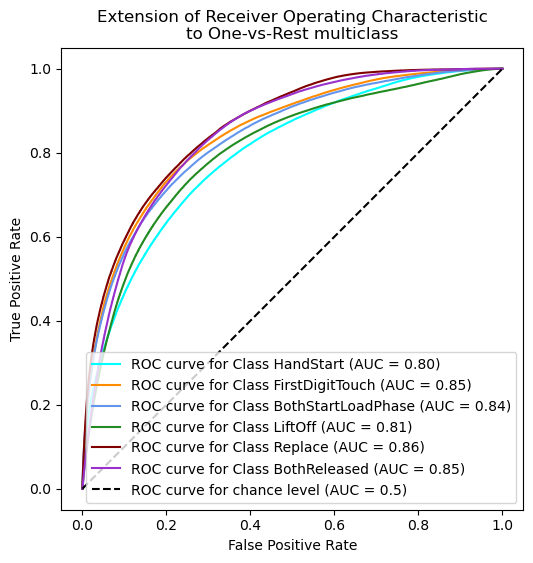

In [4]:
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

# Runs through the data to cut off final frames as required before concatenating the data
for index in range(0, len(y_pred)):
    if y_pred[index].shape[0] > y_test_data_series[index].shape[0]:
        y_pred[index].resize(y_pred[index].shape[0]-1, y_pred[index].shape[1])
        
y_score = np.concatenate(y_pred, axis=0) # confidence score for predictions
y = np.concatenate(y_test_data_series, axis=0) # true labels

# Returns AUC score for individual classes
print("Individual AUC scores for classes 1, 2, 3, 4, 5, 6: ", roc_auc_score(y, y_score, average=None))
# Returns macro-averaged AUC score
print("Macro-averaged AUC score: ", roc_auc_score(y, y_score, average='macro'))

fig, ax = plt.subplots(figsize=(6, 6))
n_classes = 6

# Plots AUC-ROC curve for each individual class vs the rest of the classes
class_names = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']
colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "maroon", "darkorchid"])
for class_id, color, class_name in zip(range(n_classes), colors, class_names):
    RocCurveDisplay.from_predictions(
        y[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for Class {class_name}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)") # Reference AUC-ROC curve for 'worst case'
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()
